### ДЗ-1 по Автоматической обработке естественного языка. Ключевые слова.

#### Настя Чижикова, БКЛ181

Данные взяты с сайта http://www.physics.uni-altai.ru/, где в разделе "Новости" можно найти много статей, для которых внизу прописаны ключевые слова (для удобного поиска по сайту)

In [308]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from summa import keywords
import RAKE
import pandas as pd
from pymorphy2 import MorphAnalyzer
from pymorphy2.tokenizers import simple_word_tokenize


stopwords = list(set(stopwords.words('russian'))) +['который']

In [283]:
data = pd.read_csv('keywords_data.csv', sep=';').dropna()

In [284]:
data.rename(columns = {'Текст': 'text', 'Разметка_данные': 'annotation_data', 'Разметка_моя': 'annotation_mine'}, 
            inplace = True)
data.head()

,text,annotation_data,annotation_mine
0,Сотрудники института физико-математического об...,астрономия; публичные наблюдения,публичные астрономические наблюдения
1,Вчера группой любителей астрономии нашего горо...,Солнце; Венера; прохождение; транзит,диск Солнца; Венера; прохождение
2,Наука терпит крах в попытках объяснить характе...,звезда; Солнце; VLT; ESO; Большое Магелланово ...,Солнце; диаграмма Герцшпрунга-Рессела; звезда;...
3,Завтра - 10 декабря - жители нашего края могут...,лунное затмение,Луна; лунное затмение
4,В России стартовала британско-российская образ...,телескоп; марка; астрономия; образование; школа,телескоп Фолкеса; школа; программа


Перед тем как составлять эталон, сделаем предобработку текстов (и еще превратим разметку в списки)

In [285]:
m = MorphAnalyzer()

def preprocess(text):
    lemmas = []
    for t in simple_word_tokenize(text):
        lemmas.append(
            m.parse(t)[0].normal_form
        )
    return ' '.join(lemmas)

def process_annotation(text: str):
    return text.split('; ')

In [286]:
data['text'] = data['text'].apply(preprocess)
data['annotation_data'] = data['annotation_data'].apply(process_annotation)
data['annotation_mine'] = data['annotation_mine'].apply(process_annotation)

Для эталона возьмем общее из моей разметки и ключевых слов с сайта, однако удалим те ключевые слова, которые не встречаются в тексте

In [287]:
def get_gold_standard(row):
    text = row['text']
    annot1 = row['annotation_data']
    annot2 = row['annotation_mine']
    
    gold_keywords = set()
    
    for keyword in annot1 + annot2:
        prep_keyword = preprocess(keyword)
        if prep_keyword in text:
            gold_keywords.add(prep_keyword)
            
    return list(gold_keywords)

In [288]:
data['keywords'] = data.apply(lambda x: get_gold_standard(x), axis=1)

In [289]:
data.head()

,text,annotation_data,annotation_mine,keywords
0,сотрудник институт физико-математический образ...,"[астрономия, публичные наблюдения]",[публичные астрономические наблюдения],[публичный астрономический наблюдение]
1,вчера группа любитель астрономия наш город быт...,"[Солнце, Венера, прохождение, транзит]","[диск Солнца, Венера, прохождение]","[прохождение, венера, диск солнце, солнце]"
2,наука терпеть крах в попытка объяснить характе...,"[звезда, Солнце, VLT, ESO, Большое Магелланово...","[Солнце, диаграмма Герцшпрунга-Рессела, звезда...","[eso, диаграмма герцшпрунг-рессело, большой ма..."
3,завтра - 10 декабрь - житель наш край мочь ста...,[лунное затмение],"[Луна, лунное затмение]","[луна, лунный затмение]"
4,в россия стартовать британско-российский образ...,"[телескоп, марка, астрономия, образование, школа]","[телескоп Фолкеса, школа, программа]","[программа, телескоп фолкес, школа, образовани..."


### Применяем модели

In [290]:
def get_kws_RAKE(text):
    rake = RAKE.Rake(stopwords)
    extracted_keywords = rake.run(text, maxWords=3, minFrequency=2)
    kw_list = [k[0] for k in extracted_keywords if k[1] > 0]

    return kw_list


def get_kws_TextRank(text):
    extracted_keywords = keywords.keywords(text, language='russian', additional_stopwords=stopwords, scores=True)
    kw_list = [k[0] for k in extracted_keywords if k[1] > 0]
    
    return kw_list


def get_kws_tfidf(corpus):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words=stopwords)
    X = vectorizer.fit_transform(corpus).toarray()
    vocab = vectorizer.get_feature_names_out()

    sorted_indx = np.argsort(X, axis=1)[:, ::-1]
    kw_list = vocab[sorted_indx[:, :5]]  #  take top-5 n-grams
    
    return list(kw_list)

In [291]:
data['kw_RAKE'] = data.text.apply(get_kws_RAKE)
data['kw_TextRank'] = data.text.apply(get_kws_TextRank)
data['kw_tfidf'] = get_kws_tfidf(data.text.to_list())

### Морфологические шаблоны

In [292]:
morph_patterns = ['NOUN',
                  'NOUN+NOUN',  # 'пояс астероидов'
                  'ADJF+NOUN',  # 'лунное затмение'
                  'ADJF+ADJF+NOUN',  # 'публичные астрономические наблюдения'
                  'LATN'  # 'NASA' и всякое другое похожее - специфика текстов про астрономию
                 ]

In [293]:
def filter_by_morph(kw_list):
    filtered_kw = []
    
    if kw_list != []:  #  иногда мы получаем пустые предсказания
        for kw in kw_list:
            tags = []
            for word in simple_word_tokenize(kw):
                tag = m.parse(word)[0].tag.POS
                
                if tag == None:
                    tag = str(m.parse(word)[0].tag)  # для нестандартных граммем типа LATN
                
                tags.append(tag)
            
            pattern = '+'.join(tags)
            
            if pattern in morph_patterns:
                filtered_kw.append(kw)

    return filtered_kw

In [294]:
data['kw_RAKE_filtered'] = data.kw_RAKE.apply(filter_by_morph)
data['kw_TextRank_filtered'] = data.kw_TextRank.apply(filter_by_morph)
data['kw_tfidf_filtered'] = data.kw_tfidf.apply(filter_by_morph)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [295]:
data.head()

,text,annotation_data,annotation_mine,keywords,kw_RAKE,kw_TextRank,kw_tfidf,kw_RAKE_filtered,kw_TextRank_filtered,kw_tfidf_filtered
0,сотрудник институт физико-математический образ...,"[астрономия, публичные наблюдения]",[публичные астрономические наблюдения],[публичный астрономический наблюдение],[],"[физико образование, институт]","[часы адрес, погодный условие состояться, год ...",[],[институт],[часы адрес]
1,вчера группа любитель астрономия наш город быт...,"[Солнце, Венера, прохождение, транзит]","[диск Солнца, Венера, прохождение]","[прохождение, венера, диск солнце, солнце]",[диск солнце],"[группа, наш, фотографический, непосредственны...","[венера диск солнце, венера, диск, диск солнце...",[диск солнце],"[группа, момент, наблюдение]","[венера, диск, диск солнце]"
2,наука терпеть крах в попытка объяснить характе...,"[звезда, Солнце, VLT, ESO, Большое Магелланово...","[Солнце, диаграмма Герцшпрунга-Рессела, звезда...","[eso, диаграмма герцшпрунг-рессело, большой ма...",[],"[звезда, наблюдение, время, феномен, обсервато...","[звезда, феномен, период, протяжение, эволюция]",[],"[звезда, наблюдение, время, феномен, обсервато...","[звезда, феномен, период, протяжение, эволюция]"
3,завтра - 10 декабрь - житель наш край мочь ста...,[лунное затмение],"[Луна, лунное затмение]","[луна, лунный затмение]",[],"[луна, лунный затмение, декабрь, житель наш]","[вечер, земной, луна, затмение, красный]",[],"[луна, лунный затмение, декабрь]","[вечер, луна, затмение]"
4,в россия стартовать британско-российский образ...,"[телескоп, марка, астрономия, образование, школа]","[телескоп Фолкеса, школа, программа]","[программа, телескоп фолкес, школа, образовани...","[школьник, гаиша, вселенная, наука, великобрит...","[программа, телескоп фолкес, астроном, это, бр...","[программа, телескоп, фолкес, телескоп фолкес,...","[школьник, гаиша, вселенная, наука, великобрит...","[программа, телескоп фолкес, астроном, система...","[программа, телескоп, фолкес, телескоп фолкес,..."


### Считаем метрики

In [296]:
def get_scores_for_one(predicted, gold_standard):
    tp = set(predicted).intersection(gold_standard) 
    fp = set(predicted) - tp
    fn = set(gold_standard) - tp
    
    return tp, fp, fn

In [297]:
def count_metrics(tp, fp, fn):
    if tp != 0:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f_score = 2 * ((precision*recall)/(precision+recall))
        metrics = {'precision': precision, 'recall': recall, 'f-score': f_score}
    else:
        metrics = {'precision': 0, 'recall': 0, 'f-score': 0}
    
    return metrics

In [298]:
def get_metrics(predicted, gold_standard):
    tp_count = 0
    fp_count = 0
    fn_count = 0
    
    for idx, pred in enumerate(predicted):
        tp, fp, fn = get_scores_for_one(pred, gold_standard[idx])
        tp_count += len(tp)
        fp_count += len(fp)
        fn_count += len(fn)
        
    metrics = count_metrics(tp_count, fp_count, fn_count)
    
    return metrics

In [299]:
metrics_df = pd.DataFrame(columns=['precision', 'recall', 'f-score'])

metrics_df.loc['RAKE'] = get_metrics(data.kw_RAKE.to_list(), data.keywords.to_list())
metrics_df.loc['TextRank'] = get_metrics(data.kw_TextRank.to_list(), data.keywords.to_list())
metrics_df.loc['tfidf'] = get_metrics(data.kw_tfidf.to_list(), data.keywords.to_list())
metrics_df.loc['RAKE_filtered'] = get_metrics(data.kw_RAKE_filtered.to_list(), data.keywords.to_list())
metrics_df.loc['TextRank_filtered'] = get_metrics(data.kw_TextRank_filtered.to_list(), data.keywords.to_list())
metrics_df.loc['tfidf_filtered'] = get_metrics(data.kw_tfidf_filtered.to_list(), data.keywords.to_list())

In [300]:
metrics_df

,precision,recall,f-score
RAKE,0.250000,0.112676,0.155340
TextRank,0.085502,0.323944,0.135294
tfidf,0.293333,0.309859,0.301370
RAKE_filtered,0.307692,0.112676,0.164948
TextRank_filtered,0.136905,0.323944,0.192469
tfidf_filtered,0.385965,0.309859,0.343750


### Анализ ошибок

Во-первых, фильтрация всегда повышает качество выделения - увеличивает точность и не ухудшает полноту. Интересно, что лучшей моделью стала простая TfIdf векторизация. Возможно, дело в том, что более сложные методы плохо справляются с короткими текстами (длина текстов в моем корпусе варьируется, некоторые совсем короткие, и даже самые длинные все еще длиной не больше 500 токенов). Посчитаем метрики для каждого текста по отдельности и посмотрим, как они зависят от длины текста).

In [303]:
def get_text_length(text):
    return len(simple_word_tokenize(text))

new_df = pd.DataFrame()
new_df['text_len'] = data.text.apply(get_text_length)

In [304]:
def get_metrics_for_text(row, model: str):
    predicted, gold_standard = row[f'kw_{model}'], row['keywords']
    
    if predicted != []:
        tp, fp, fn = get_scores_for_one(predicted, gold_standard)
        metrics = count_metrics(len(tp), len(fp), len(fn))
    else:
        return 0
    
    return metrics['f-score']

In [305]:
models = list(metrics_df.index)

for model in models:
    new_df[f'f-score_{model}'] = data.apply(lambda x: get_metrics_for_text(x, model=model), axis=1)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [306]:
new_df.head()

,text_len,f-score_RAKE,f-score_TextRank,f-score_tfidf,f-score_RAKE_filtered,f-score_TextRank_filtered,f-score_tfidf_filtered
0,36,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,64,0.4,0.000000,0.444444,0.4,0.000000,0.571429
2,261,0.0,0.068966,0.181818,0.0,0.125000,0.181818
3,63,0.0,0.666667,0.285714,0.0,0.800000,0.400000
4,612,0.0,0.163265,0.545455,0.0,0.242424,0.545455


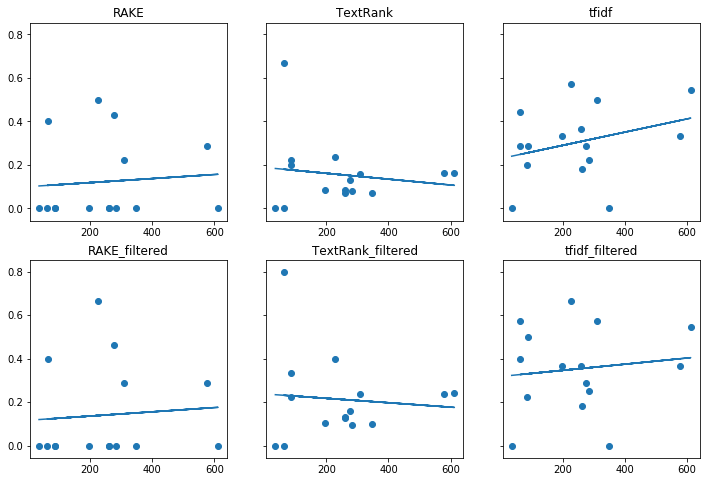

In [317]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey=True)

i = 0
for row in ax:
    for col in row:
        x = new_df.text_len
        y = new_df[f'f-score_{models[i]}']
        col.scatter(x, y)
        col.set_title(models[i])
        
        m, b = np.polyfit(x, y, 1)
        col.plot(x, m*x + b)

        i += 1

Гипотеза не оправдалась - RAKE делает пустые предсказания и на длинных, и на коротких текстах.

Что можно было бы улучшить: использовать синтаксис, выделять именные группы, а не просто последовательности, да и вообще использовать более длинные тексты.